# High Frequency Bubble Target Strength Validation

This notebook validates bubble target strength calculations at high frequencies by comparing three different acoustic scattering models:

1. **Medwin-Clay Model** (Weber et al. 2014): Classical resonance-based approach with thermal corrections
2. **Thuraisingham Model** (Zhang et al. 2022): Advanced model considering generalized compressibility 
3. **Breathing Model**: Simplified resonance model with thermal diffusivity effects

## Objective
Compare target strength predictions across a range of bubble sizes (1-5 mm radius) for both conventional (18 kHz) and high frequency (1000 kHz) sonar systems to evaluate model performance and convergence at extreme frequencies.

## Refs

Herman Medwin and Clarence S. Clay (1998), Fundamentals of Acoustical Oceanography. Academic Press https://doi.org/10.1016/B978-0-12-487570-8.X5000-4

Weber, T. C., L. Mayer, K. Jerram, J. Beaudoin, Y. Rzhanov, and D. Lovalvo (2014), Acoustic estimates of methane gas flux from the seabed in a 6000 km2 region in the Northern Gulf of Mexico, Geochem. Geophys. Geosyst., 15, 1911–1925, doi:10.1002/2014GC005271.

Zhang, W.; Zhou, T.; Li, J.; Xu, C. An Efficient Method for Detection and Quantitation of Underwater Gas Leakage Based on a 300-kHz Multibeam Sonar. Remote Sens. 2022, 14, 4301. https://doi.org/10.3390/rs14174301


## Import Required Libraries

Import necessary libraries including NumPy, Matplotlib, and the SeaEcho water bubble modules.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from pathlib import Path
import importlib

# Add project root to path for imports
PROJECT_ROOT = Path(__file__).resolve().parent.parent if '__file__' in globals() else Path().resolve().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# Import SeaEcho modules
from utils.SeaEcho_water import seawater
from utils.SeaEcho_gas_bubble import air_bubble

# Import bubble scattering models
from Bubble.models.medwin_clay_model import calculate_medwin_clay_ts
from Bubble.models.thuraisingham_model import calculate_thuraisingham_ts
from Bubble.models.breathing_model import calculate_breathing_ts

# Set matplotlib parameters
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

print("✓ All imports successful!")
print("✓ High frequency validation modules loaded")

✓ All imports successful!
✓ High frequency validation modules loaded


## Define Environmental Parameters

Set up environmental conditions including depth, salinity, temperature, and calculate sound speed using seawater properties.

In [2]:
# Environmental parameters (Gulf of Mexico conditions from Weber et al. 2014)
z = 500  # Depth in meters
S = 35   # Salinity in PSU (practical salinity units)
T = 10   # Temperature in °C (Gulf of Mexico at 500m depth)

# Create seawater object
water = seawater(T, z, S)

# Calculate sound speed using the water object
c = water.sound_speed()



## Setup High Frequency Array

Define high frequency values for validation, extending beyond the original 18 kHz and 1000 kHz to test model performance at higher frequencies.

In [3]:
# Define sonar frequencies for comparison
f = np.array([18, 1000])  # Frequencies in kHz: conventional vs high frequency

print(f"Frequency Array:")
print(f"  Conventional frequency: {f[0]} kHz")
print(f"  High frequency: {f[1]} kHz")
print(f"  Frequency ratio: {f[1]/f[0]:.1f}x higher")

# Calculate wavelengths for context
wavelength_18 = c / (f[0] * 1000)  # Convert kHz to Hz
wavelength_1000 = c / (f[1] * 1000)  # Convert kHz to Hz

print(f"\nWavelength Analysis:")
print(f"  18 kHz wavelength: {wavelength_18:.3f} m")
print(f"  1000 kHz wavelength: {wavelength_1000:.4f} m")
print(f"  Wavelength ratio: {wavelength_18/wavelength_1000:.1f}x longer for 18 kHz")

Frequency Array:
  Conventional frequency: 18 kHz
  High frequency: 1000 kHz
  Frequency ratio: 55.6x higher

Wavelength Analysis:
  18 kHz wavelength: 0.083 m
  1000 kHz wavelength: 0.0015 m
  Wavelength ratio: 55.6x longer for 18 kHz


## Initialize Bubble Radius Array

Create a range of bubble radii for testing, maintaining the original 1-5 mm range with high resolution.

In [4]:
# Create bubble radius array: 1-5 mm with high resolution (2000 points)
a = np.linspace(1, 5, 2000) * 1e-3  # Convert from mm to meters

print(f"Bubble Radius Array:")
print(f"  Range: {a.min()*1e3:.1f} - {a.max()*1e3:.1f} mm")
print(f"  Resolution: {len(a)} points")
print(f"  Step size: {(a[1]-a[0])*1e6:.1f} μm")

# Calculate ka (dimensionless size parameter) for context
ka_18_min = 2 * np.pi * f[0] * 1000 * a.min() / c
ka_18_max = 2 * np.pi * f[0] * 1000 * a.max() / c
ka_1000_min = 2 * np.pi * f[1] * 1000 * a.min() / c
ka_1000_max = 2 * np.pi * f[1] * 1000 * a.max() / c

print(f"\nDimensionless Size Parameter (ka) Ranges:")
print(f"  18 kHz: {ka_18_min:.3f} - {ka_18_max:.2f}")
print(f"  1000 kHz: {ka_1000_min:.2f} - {ka_1000_max:.1f}")
print(f"  High frequency regime (ka >> 1) reached for bubbles > {c/(2*np.pi*f[1]*1000)*1e3:.2f} mm")

Bubble Radius Array:
  Range: 1.0 - 5.0 mm
  Resolution: 2000 points
  Step size: 2.0 μm

Dimensionless Size Parameter (ka) Ranges:
  18 kHz: 0.075 - 0.38
  1000 kHz: 4.19 - 21.0
  High frequency regime (ka >> 1) reached for bubbles > 0.24 mm


## Calculate Target Strength for Multiple Models

Compute Target Strength values using Medwin-Clay, Thuraisingham, and Breathing models for each frequency and bubble size combination.

In [5]:
# Initialize target strength arrays for each model and frequency
TS_medwin_clay_18 = np.zeros(len(a))
TS_medwin_clay_1000 = np.zeros(len(a))
TS_thuraisingham_18 = np.zeros(len(a))
TS_thuraisingham_1000 = np.zeros(len(a))
TS_breathing_18 = np.zeros(len(a))
TS_breathing_1000 = np.zeros(len(a))

print("Calculating target strength for all models and frequencies...")
print(f"Processing {len(a)} bubble radii × 3 models × 2 frequencies = {len(a)*3*2} calculations")

# Loop through each bubble radius
for ida, ai in enumerate(a):
    # Create air bubble object (diameter = 2 * radius)
    bubble = air_bubble(water, T, z, S, ai * 2)
    
    try:
        # Calculate target strength for 18 kHz
        TS_medwin_clay_18[ida] = calculate_medwin_clay_ts(f[0], c, water, bubble)
        TS_thuraisingham_18[ida] = calculate_thuraisingham_ts(f[0], c, water, bubble)
        TS_breathing_18[ida] = calculate_breathing_ts(f[0], c, water, bubble)
        
        # Calculate target strength for 1000 kHz
        TS_medwin_clay_1000[ida] = calculate_medwin_clay_ts(f[1], c, water, bubble)
        TS_thuraisingham_1000[ida] = calculate_thuraisingham_ts(f[1], c, water, bubble)
        TS_breathing_1000[ida] = calculate_breathing_ts(f[1], c, water, bubble)
        
    except Exception as e:
        # If calculation fails, set to NaN
        TS_medwin_clay_18[ida] = np.nan
        TS_medwin_clay_1000[ida] = np.nan
        TS_thuraisingham_18[ida] = np.nan
        TS_thuraisingham_1000[ida] = np.nan
        TS_breathing_18[ida] = np.nan
        TS_breathing_1000[ida] = np.nan
        
        if ida % 500 == 0:  # Only print occasional errors to avoid spam
            print(f"  Warning: Calculation failed for radius {ai*1e3:.2f} mm: {e}")
    
    # Progress indicator
    if (ida + 1) % 400 == 0:
        progress = (ida + 1) / len(a) * 100
        print(f"  Progress: {progress:.1f}% ({ida + 1}/{len(a)} calculations)")

print("✓ Target strength calculations completed!")

# Calculate valid data statistics
valid_18_counts = [
    np.sum(~np.isnan(TS_medwin_clay_18)),
    np.sum(~np.isnan(TS_thuraisingham_18)),
    np.sum(~np.isnan(TS_breathing_18))
]

valid_1000_counts = [
    np.sum(~np.isnan(TS_medwin_clay_1000)),
    np.sum(~np.isnan(TS_thuraisingham_1000)),
    np.sum(~np.isnan(TS_breathing_1000))
]

model_names = ['Medwin-Clay', 'Thuraisingham', 'Breathing']

print(f"\nValid Data Points:")
for i, model in enumerate(model_names):
    print(f"  {model}: {valid_18_counts[i]}/{len(a)} (18 kHz), {valid_1000_counts[i]}/{len(a)} (1000 kHz)")

Calculating target strength for all models and frequencies...
Processing 2000 bubble radii × 3 models × 2 frequencies = 12000 calculations
  Progress: 20.0% (400/2000 calculations)
  Progress: 40.0% (800/2000 calculations)
  Progress: 60.0% (1200/2000 calculations)
  Progress: 80.0% (1600/2000 calculations)
  Progress: 100.0% (2000/2000 calculations)
✓ Target strength calculations completed!

Valid Data Points:
  Medwin-Clay: 2000/2000 (18 kHz), 2000/2000 (1000 kHz)
  Thuraisingham: 2000/2000 (18 kHz), 2000/2000 (1000 kHz)
  Breathing: 2000/2000 (18 kHz), 2000/2000 (1000 kHz)
  Progress: 100.0% (2000/2000 calculations)
✓ Target strength calculations completed!

Valid Data Points:
  Medwin-Clay: 2000/2000 (18 kHz), 2000/2000 (1000 kHz)
  Thuraisingham: 2000/2000 (18 kHz), 2000/2000 (1000 kHz)
  Breathing: 2000/2000 (18 kHz), 2000/2000 (1000 kHz)


/Users/wangbinb/Library/CloudStorage/OneDrive-UniversityofMissouri/ONR_project/seaEchoTSCalculator/utils/SeaEcho_acoustic_paras.py:41: UserWarning: ka < 1 not satisfied!
  warnings.warn("ka < 1 not satisfied!")
/Users/wangbinb/Library/CloudStorage/OneDrive-UniversityofMissouri/ONR_project/seaEchoTSCalculator/utils/SeaEcho_acoustic_paras.py:71: RuntimeWarning: overflow encountered in sinh
  temporary1 = X * (np.sinh(X) + np.sin(X)) - 2 * (np.cosh(X) - np.cos(X))
/Users/wangbinb/Library/CloudStorage/OneDrive-UniversityofMissouri/ONR_project/seaEchoTSCalculator/utils/SeaEcho_acoustic_paras.py:71: RuntimeWarning: overflow encountered in cosh
  temporary1 = X * (np.sinh(X) + np.sin(X)) - 2 * (np.cosh(X) - np.cos(X))
/Users/wangbinb/Library/CloudStorage/OneDrive-UniversityofMissouri/ONR_project/seaEchoTSCalculator/utils/SeaEcho_acoustic_paras.py:71: RuntimeWarning: invalid value encountered in scalar subtract
  temporary1 = X * (np.sinh(X) + np.sin(X)) - 2 * (np.cosh(X) - np.cos(X))
/Users/w

## Create Comparison Plots

Generate subplots comparing the three models across different frequencies, with proper scaling and legends for high frequency validation.

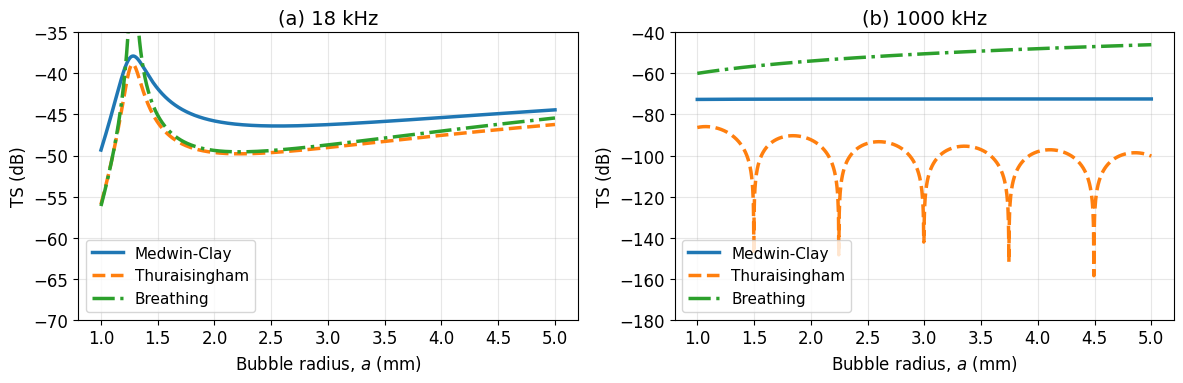

✓ High frequency comparison plots created and saved!
  Location: /Users/wangbinb/Library/CloudStorage/OneDrive-UniversityofMissouri/ONR_project/seaEchoTSCalculator/plots/high_frequency_model_comparison.pdf


In [6]:
# Create comparison plots (reproducing and extending your original figure)
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Define colors and line styles for better distinction
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Professional blue, orange, green
line_styles = ['-', '--', '-.']
model_labels = ['Medwin-Clay', 'Thuraisingham', 'Breathing']

# Plot for 18 kHz (left panel)
axs[0].plot(a * 1e3, TS_medwin_clay_18, color=colors[0], linewidth=2.5, 
           linestyle=line_styles[0], label=model_labels[0])
axs[0].plot(a * 1e3, TS_thuraisingham_18, color=colors[1], linewidth=2.5, 
           linestyle=line_styles[1], label=model_labels[1])
axs[0].plot(a * 1e3, TS_breathing_18, color=colors[2], linewidth=2.5, 
           linestyle=line_styles[2], label=model_labels[2])

axs[0].set_xlabel(r'Bubble radius, $a$ (mm)', fontsize=12)
axs[0].set_ylabel('TS (dB)', fontsize=12)
axs[0].set_title('(a) 18 kHz', fontsize=14)
axs[0].set_ylim([-70, -35])
axs[0].grid(True, alpha=0.3)
axs[0].legend(fontsize=11)

# Plot for 1000 kHz (right panel)
axs[1].plot(a * 1e3, TS_medwin_clay_1000, color=colors[0], linewidth=2.5, 
           linestyle=line_styles[0], label=model_labels[0])
axs[1].plot(a * 1e3, TS_thuraisingham_1000, color=colors[1], linewidth=2.5, 
           linestyle=line_styles[1], label=model_labels[1])
axs[1].plot(a * 1e3, TS_breathing_1000, color=colors[2], linewidth=2.5, 
           linestyle=line_styles[2], label=model_labels[2])

axs[1].set_xlabel(r'Bubble radius, $a$ (mm)', fontsize=12)
axs[1].set_ylabel('TS (dB)', fontsize=12)
axs[1].set_title('(b) 1000 kHz', fontsize=14)
axs[1].set_ylim([-180, -40])
axs[1].grid(True, alpha=0.3)
axs[1].legend(fontsize=11)

plt.tight_layout()

# Save plots to main plots folder only
output_path = PROJECT_ROOT / "plots" / "high_frequency_model_comparison.pdf"
output_path.parent.mkdir(exist_ok=True)
plt.savefig(output_path, dpi=300, bbox_inches='tight')

plt.show()

print(f"✓ High frequency comparison plots created and saved!")
print(f"  Location: {output_path}")